In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import scipy.stats as stats

import random
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/CS 2756 Data Mining/Term Project/ev_charging_patterns_dataset.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [ ]:
# Let's drop User ID right away
df.drop('User ID', axis=1, inplace=True)

In [ ]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Vehicle Model                             1320 non-null   object 
 1   Battery Capacity (kWh)                    1320 non-null   float64
 2   Charging Station ID                       1320 non-null   object 
 3   Charging Station Location                 1320 non-null   object 
 4   Charging Start Time                       1320 non-null   object 
 5   Charging End Time                         1320 non-null   object 
 6   Energy Consumed (kWh)                     1254 non-null   float64
 7   Charging Duration (hours)                 1320 non-null   float64
 8   Charging Rate (kW)                        1254 non-null   float64
 9   Charging Cost (USD)                       1320 non-null   float64
 10  Time of Day                         

# Exploratory Data Analysis (EDA)

Let's see the most popular cars among different User Types

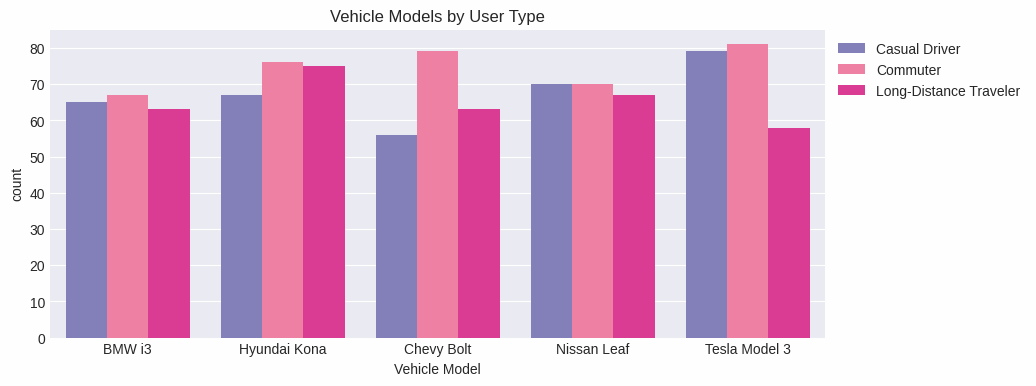

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(
    df, x='Vehicle Model',
    hue='User Type',
    hue_order=['Casual Driver', 'Commuter', 'Long-Distance Traveler']
)
plt.title("Vehicle Models by User Type")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Chevy Bolt and Tesla Model 3 are more popular among commuters which makes sense considering these are US companies and data is from USA regions.

Here's some plots that when different users prefer to charge theirs car

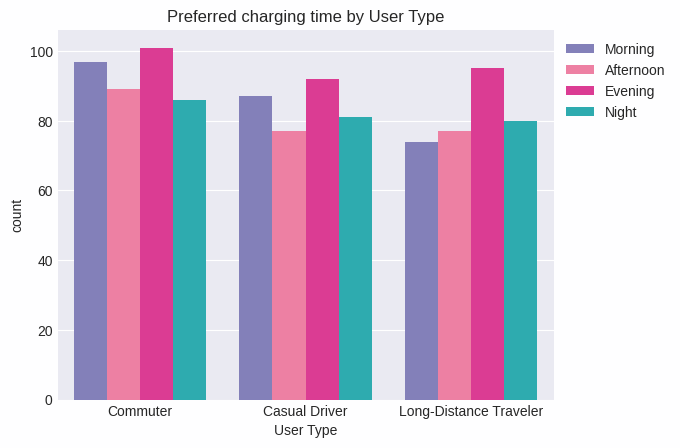

In [ ]:
sns.countplot(df, x='User Type', hue='Time of Day', hue_order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title("Preferred charging time by User Type")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

There's no significant difference in the preferred time of day, except for a slight preference: Casuals and Commuters tend to charge in the morning and evening, while Long-Distance Travelers prefer the evening.

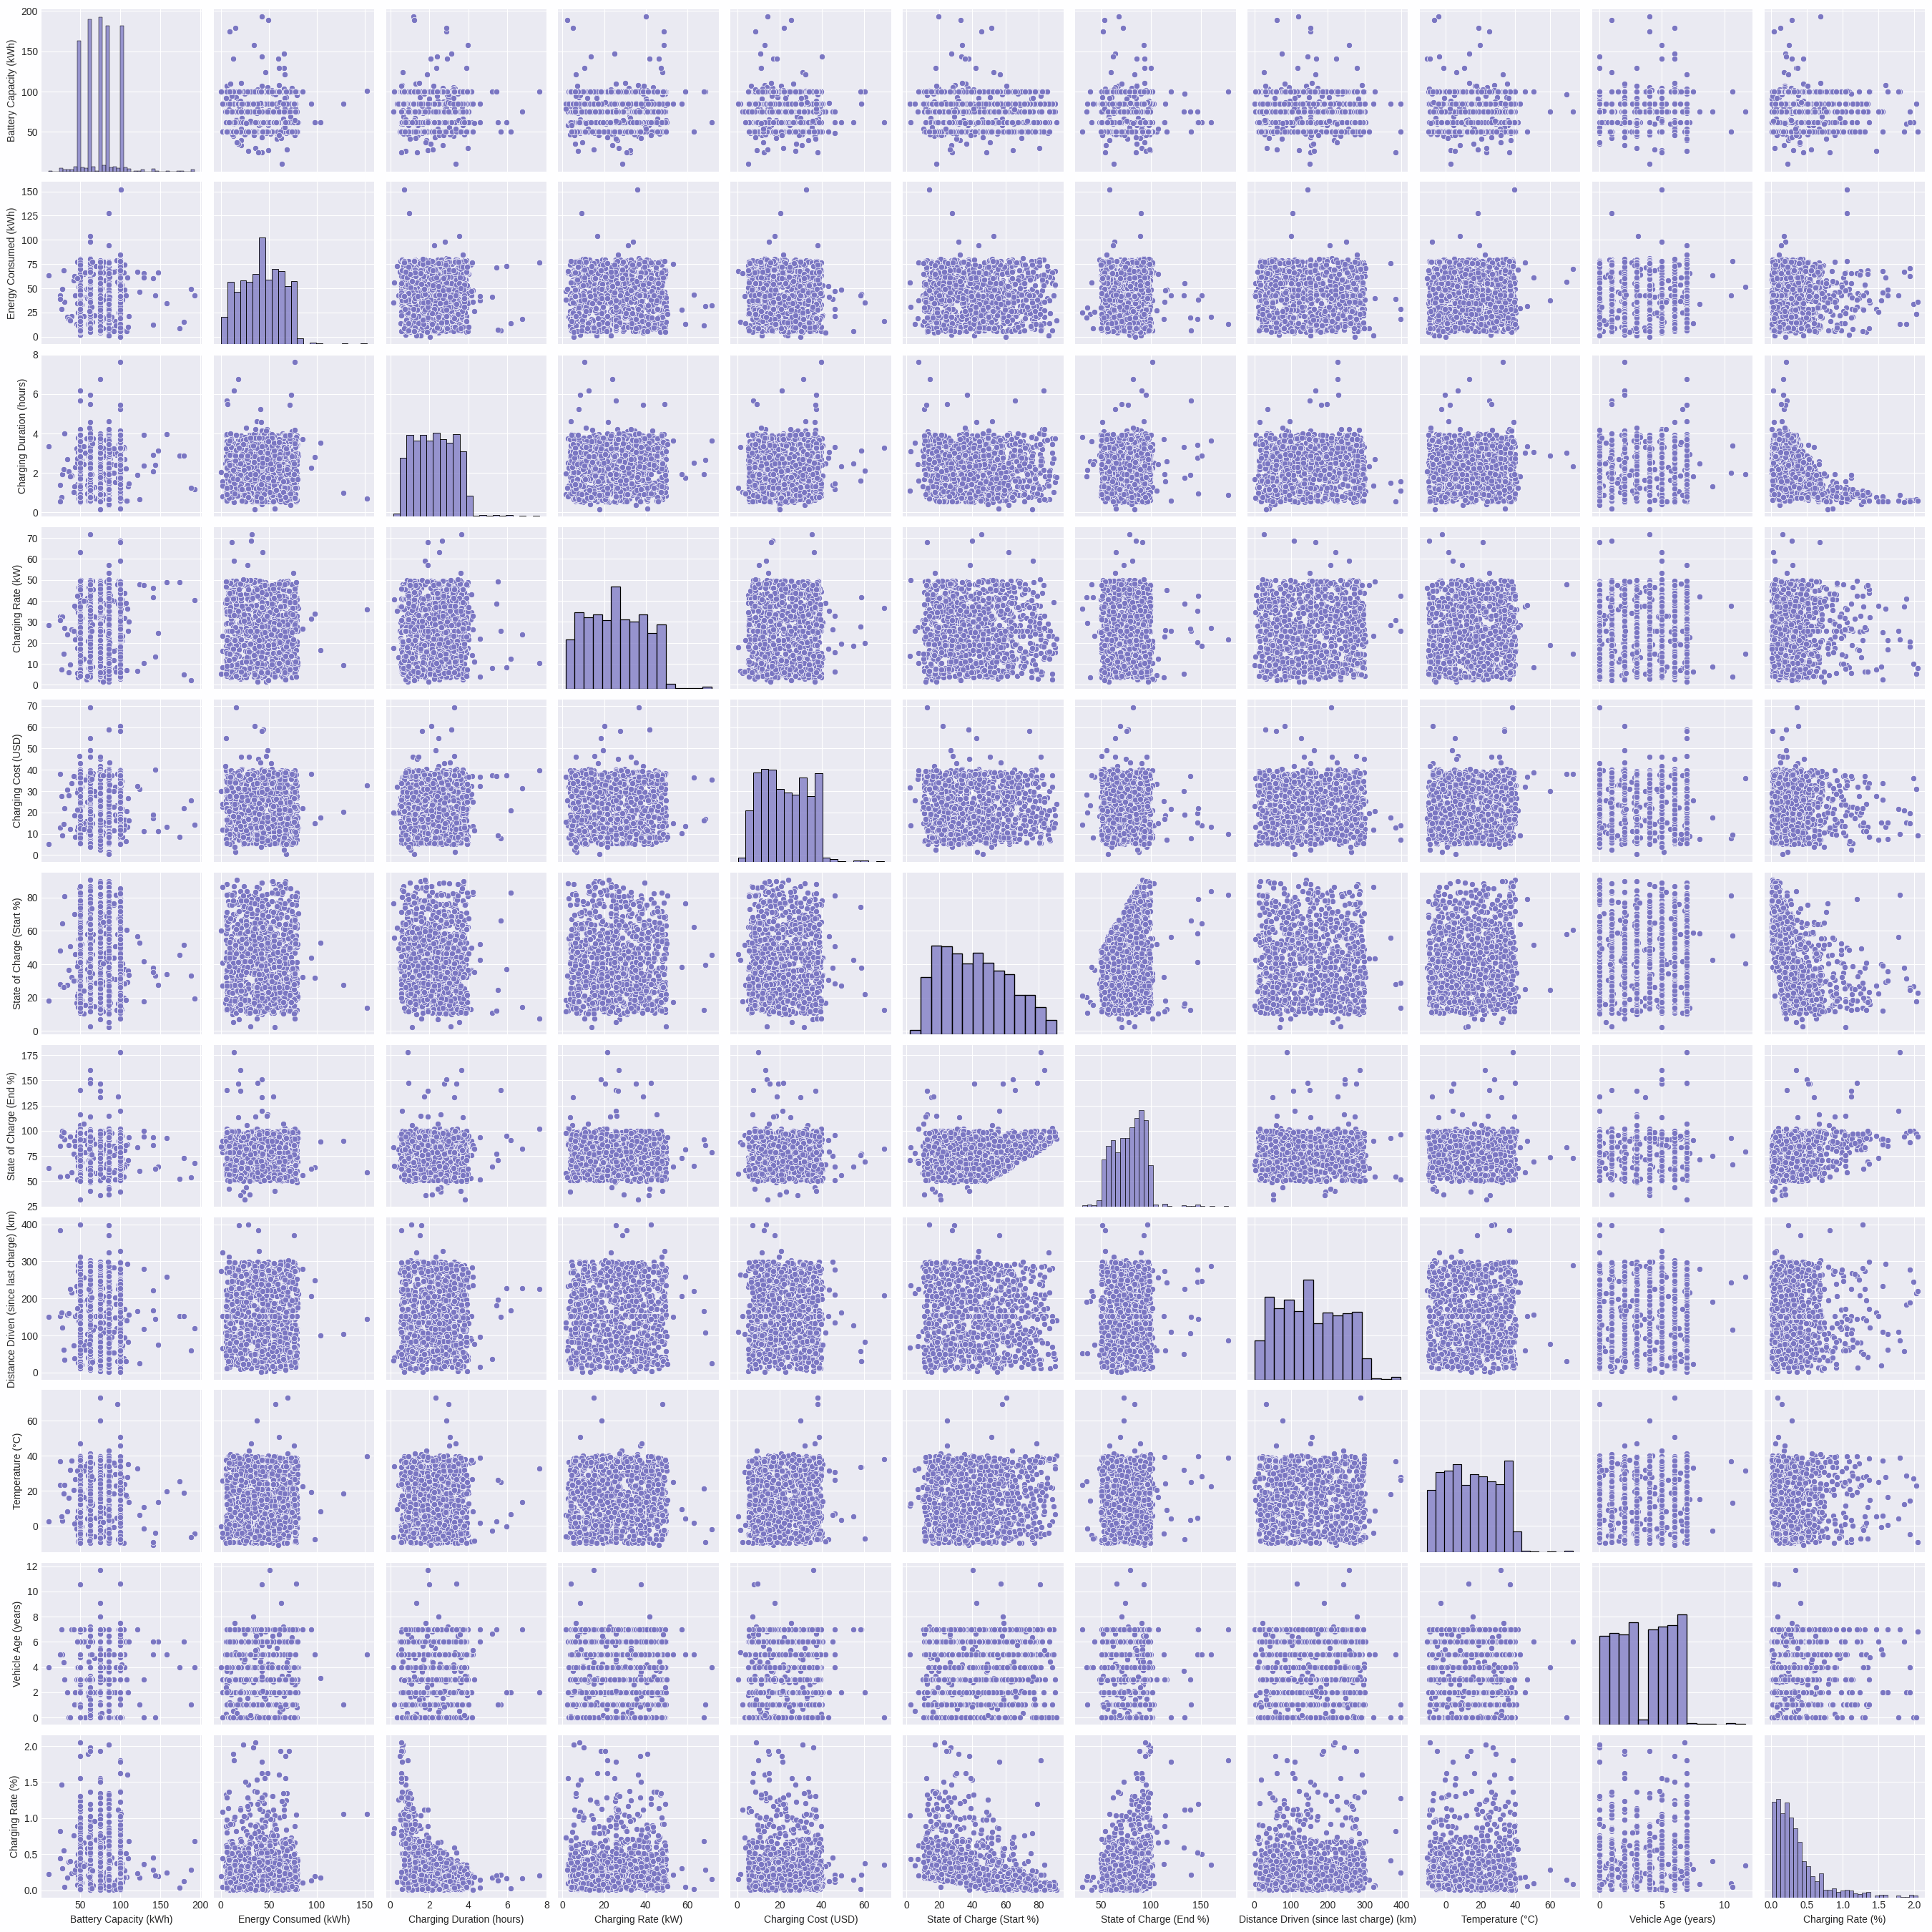

In [ ]:
sns.pairplot(df)

# Data Preprocessing

Missing Values Summary:
User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station Location                    0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
dtype: int64


<ipython-input-4-2d12fde2c7c2>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_reduced['Energy Consumed (kWh)'].fillna(df_reduced['Energy Consumed (kWh)'].mean(), inplace=True)
<ipython-input-4-2d12fde2c7c2>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

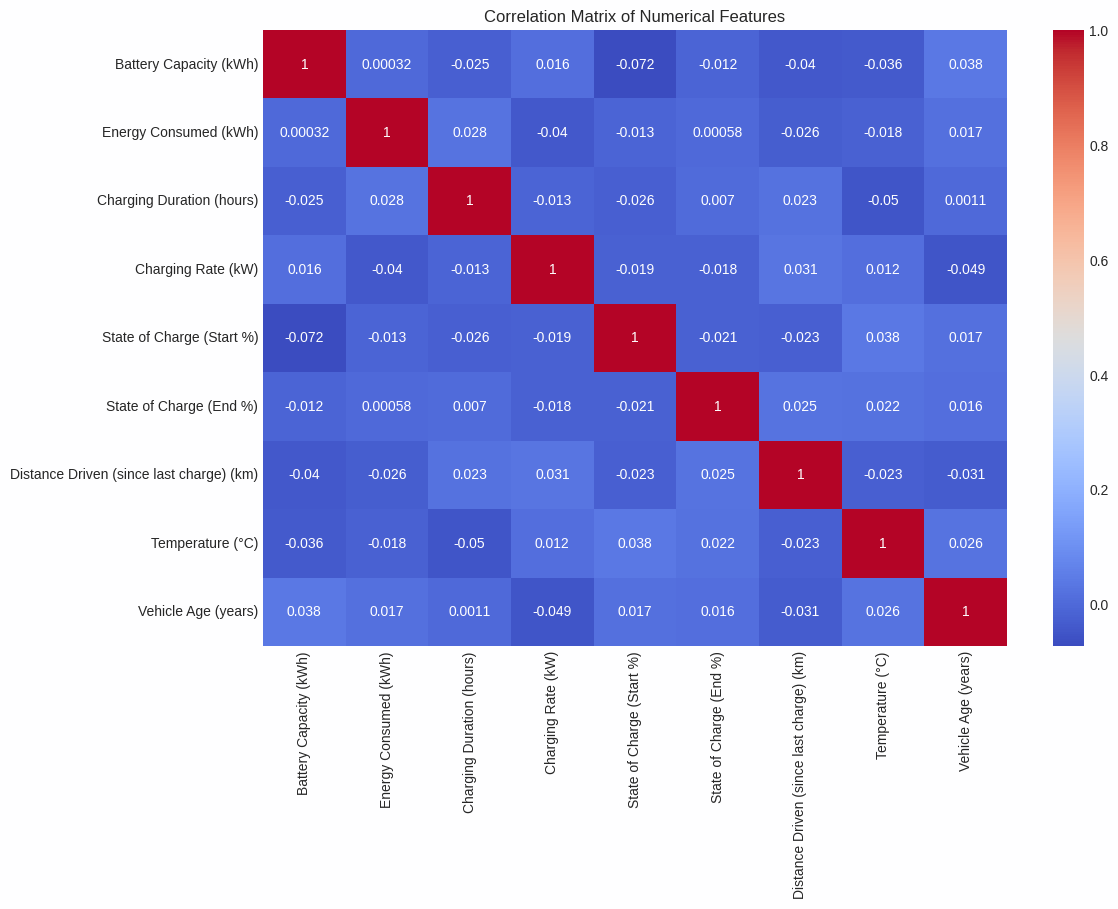

Feature Variability (Standard Deviation):
Battery Capacity (kWh)                      1.000379
Energy Consumed (kWh)                       1.000379
Charging Duration (hours)                   1.000379
Charging Rate (kW)                          1.000379
State of Charge (Start %)                   1.000379
State of Charge (End %)                     1.000379
Distance Driven (since last charge) (km)    1.000379
Temperature (°C)                            1.000379
Vehicle Age (years)                         1.000379
dtype: float64
Prepared Clustering Data:
   Battery Capacity (kWh)  Energy Consumed (kWh)  Charging Duration (hours)  \
0                1.645480               0.827526                  -1.582085   
1                1.235035              -1.387813                   0.814865   
2                0.022567              -1.076870                   0.172798   
3               -1.189901               1.686011                  -0.945610   
4               -1.189901              -1.053

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Step 1: Drop Irrelevant Columns
irrelevant_columns = ['Charging Station ID', 'Charging Start Time', 'Charging End Time', 'User Type']
df_reduced = df.drop(columns=irrelevant_columns)

# Step 2: Analyze Missing Values
missing_summary = df_reduced.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)

# Impute missing values for numerical columns
df_reduced['Energy Consumed (kWh)'].fillna(df_reduced['Energy Consumed (kWh)'].mean(), inplace=True)
df_reduced['Charging Rate (kW)'].fillna(df_reduced['Charging Rate (kW)'].mean(), inplace=True)
df_reduced['Distance Driven (since last charge) (km)'].fillna(
    df_reduced['Distance Driven (since last charge) (km)'].mean(), inplace=True
)

# Step 3: Encode Categorical Columns
categorical_columns = ['Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_reduced[col] = le.fit_transform(df_reduced[col])
    label_encoders[col] = le

# Step 4: Correlation Analysis for Numerical Columns
numerical_columns = [
    'Battery Capacity (kWh)', 'Energy Consumed (kWh)', 'Charging Duration (hours)', 'Charging Rate (kW)',
    'State of Charge (Start %)', 'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
    'Temperature (°C)', 'Vehicle Age (years)'
]
correlation_matrix = df_reduced[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Step 5: Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_reduced[numerical_columns])

# Add scaled features back to the dataset
scaled_features = pd.DataFrame(scaled_data, columns=numerical_columns)
df_reduced[numerical_columns] = scaled_features

# Step 6: Feature Variability
feature_variability = df_reduced[numerical_columns].std()
print("Feature Variability (Standard Deviation):")
print(feature_variability)

# Step 7: Prepare Data for Clustering
clustering_data = df_reduced[numerical_columns + categorical_columns]
print("Prepared Clustering Data:")
print(clustering_data.head())


# Feature Importance Based on Silhouette Score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Define categorical and numerical features
categorical_features = [
    "Vehicle Model", "Charging Station Location", "Time of Day",
    "Day of Week", "Charger Type", "User Type"
]
numerical_features = [
    "Battery Capacity (kWh)", "Energy Consumed (kWh)", "Charging Duration (hours)",
    "Charging Rate (kW)", "State of Charge (Start %)", "State of Charge (End %)",
    "Distance Driven (since last charge) (km)", "Temperature (°C)", "Vehicle Age (years)"
]

# Create a dictionary to store the mapping of original labels to encoded labels
label_mappings = {}

# Encode categorical features and store mappings
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_mappings[col] = dict(zip(le.classes_, range(len(le.classes_))))

# Print the encoded and original labels for each categorical feature
print("Encoded Labels and Original Labels for Categorical Features:")
for feature, mapping in label_mappings.items():
    print(f"\nFeature: {feature}")
    for original, encoded in mapping.items():
        print(f"  {original}: {encoded}")

# Fill missing values in numerical columns
for col in numerical_features:
    df[col].fillna(df[col].mean(), inplace=True)

# Combine all features for evaluation
all_features = numerical_features + categorical_features

# Function to evaluate feature importance for clustering
def evaluate_all_features(data, features):
    results = []
    for feature in features:
        # Use all other features except the current one
        selected_features = [f for f in features if f != feature]
        kmeans = KMeans(n_clusters=3, random_state=42)
        labels = kmeans.fit_predict(data[selected_features])
        silhouette_avg = silhouette_score(data[selected_features], labels)
        results.append((feature, silhouette_avg))
    return sorted(results, key=lambda x: x[1], reverse=True)

# Perform evaluation
all_feature_evaluation = evaluate_all_features(df, all_features)

# Display results
all_feature_evaluation_df = pd.DataFrame(
    all_feature_evaluation, columns=["Feature", "Silhouette Score"]
)
print("\nFeature Importance Based on Silhouette Score:")
print(all_feature_evaluation_df)


Encoded Labels and Original Labels for Categorical Features:

Feature: Vehicle Model
  BMW i3: 0
  Chevy Bolt: 1
  Hyundai Kona: 2
  Nissan Leaf: 3
  Tesla Model 3: 4

Feature: Charging Station Location
  Chicago: 0
  Houston: 1
  Los Angeles: 2
  New York: 3
  San Francisco: 4

Feature: Time of Day
  Afternoon: 0
  Evening: 1
  Morning: 2
  Night: 3

Feature: Day of Week
  Friday: 0
  Monday: 1
  Saturday: 2
  Sunday: 3
  Thursday: 4
  Tuesday: 5
  Wednesday: 6

Feature: Charger Type
  DC Fast Charger: 0
  Level 1: 1
  Level 2: 2

Feature: User Type
  Casual Driver: 0
  Commuter: 1
  Long-Distance Traveler: 2


<ipython-input-4-3f82aabe2a6b>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)



Feature Importance Based on Silhouette Score:
                                     Feature  Silhouette Score
0                  State of Charge (Start %)          0.360731
1                      Energy Consumed (kWh)          0.354181
2                     Battery Capacity (kWh)          0.349266
3                    State of Charge (End %)          0.341522
4                           Temperature (°C)          0.337751
5                         Charging Rate (kW)          0.335297
6                        Vehicle Age (years)          0.323304
7                                Day of Week          0.323217
8                              Vehicle Model          0.323075
9                  Charging Station Location          0.323069
10                               Time of Day          0.323020
11                 Charging Duration (hours)          0.323016
12                              Charger Type          0.322984
13                                 User Type          0.322982
14  Dist

# Refined features and optimal K

Refined Clustering Silhouette Score: 0.159


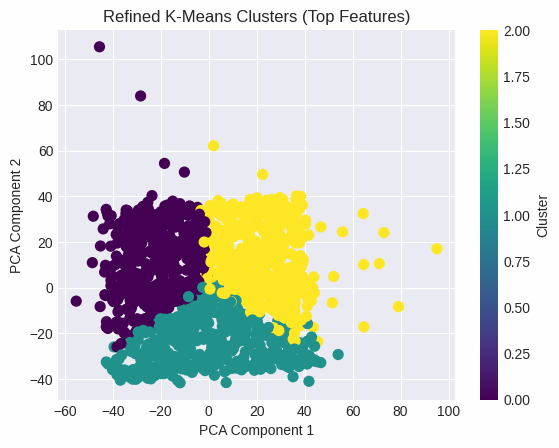

In [ ]:
# Refined feature set based on importance
refined_features = [
    'State of Charge (Start %)', 'Energy Consumed (kWh)', 'Battery Capacity (kWh)',
    'State of Charge (End %)', 'Temperature (°C)', 'Charging Rate (kW)', 'Vehicle Model'
]

# Perform clustering with the refined feature set
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df[refined_features])

# Evaluate clustering performance
silhouette_avg = silhouette_score(df[refined_features], labels)
print(f"Refined Clustering Silhouette Score: {silhouette_avg:.3f}")

# Visualize clusters in 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df[refined_features])

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Refined K-Means Clusters (Top Features)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 10)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(df[refined_features])
    silhouette_avg = silhouette_score(df[refined_features], labels)
    silhouette_scores.append((n_clusters, silhouette_avg))

# Display silhouette scores
for n_clusters, score in silhouette_scores:
    print(f"K={n_clusters}, Silhouette Score={score:.3f}")


K=2, Silhouette Score=0.187
K=3, Silhouette Score=0.159
K=4, Silhouette Score=0.146
K=5, Silhouette Score=0.143
K=6, Silhouette Score=0.135
K=7, Silhouette Score=0.134
K=8, Silhouette Score=0.130
K=9, Silhouette Score=0.125


K=2 Clustering Silhouette Score: 0.187


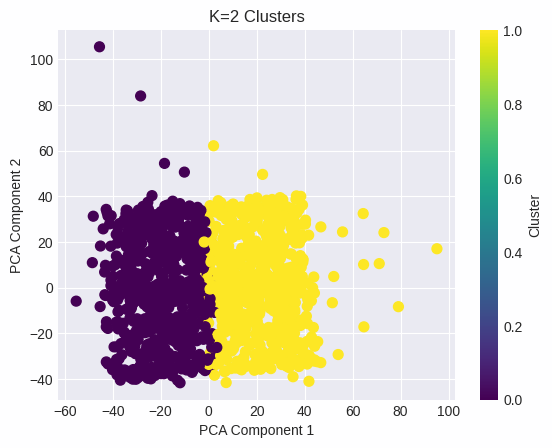

In [ ]:
# Perform clustering with K=2
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(df[refined_features])

# Evaluate clustering performance
silhouette_avg = silhouette_score(df[refined_features], labels)
print(f"K=2 Clustering Silhouette Score: {silhouette_avg:.3f}")

# Visualize clusters in 2D using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df[refined_features])

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', s=50)
plt.title("K=2 Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


# Classification Performance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
import numpy as np

# Adding cluster labels to the dataset for regression/classification
df['Cluster'] = labels

# Define features and targets
regression_features = refined_features  # Features used for regression
classification_features = refined_features  # Features used for classification
regression_target = 'Charging Cost (USD)'
classification_target = 'Cluster'

# Train-test split for regression
X_reg, X_reg_test, y_reg, y_reg_test = train_test_split(
    df[regression_features], df[regression_target], test_size=0.2, random_state=42
)

# Train-test split for classification
X_clf, X_clf_test, y_clf, y_clf_test = train_test_split(
    df[classification_features], df[classification_target], test_size=0.2, random_state=42
)

# Perform regression
regressor = RandomForestRegressor(random_state=42, n_estimators=100)
regressor.fit(X_reg, y_reg)
y_reg_pred = regressor.predict(X_reg_test)

# Evaluate regression
r2 = r2_score(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
print(f"Regression R²: {r2:.3f}")
print(f"Regression RMSE: {rmse:.3f}")

# Perform classification
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_clf, y_clf)
y_clf_pred = classifier.predict(X_clf_test)

# Evaluate classification
accuracy = accuracy_score(y_clf_test, y_clf_pred)
f1 = f1_score(y_clf_test, y_clf_pred, average='weighted')
print(f"Classification Accuracy: {accuracy:.3f}")
print(f"Classification F1-Score: {f1:.3f}")



Regression R²: -0.058
Regression RMSE: 11.521
Classification Accuracy: 0.996
Classification F1-Score: 0.996


# K=2 Clusters Analysis

In [ ]:
# Summarize numerical features by cluster
numerical_summary = df.groupby('Cluster')[numerical_features].mean()

# Summarize categorical features by cluster
categorical_summary = {}
for feature in categorical_features:
    categorical_summary[feature] = df.groupby('Cluster')[feature].value_counts(normalize=True)

# Display results
print("Numerical Feature Summary by Cluster:")
print(numerical_summary)

print("\nCategorical Feature Summary by Cluster:")
for feature, summary in categorical_summary.items():
    print(f"\n{feature} Distribution:")
    print(summary)


Numerical Feature Summary by Cluster:
         Battery Capacity (kWh)  Energy Consumed (kWh)  \
Cluster                                                  
0                     77.036323              43.240926   
1                     71.892782              42.011328   

         Charging Duration (hours)  Charging Rate (kW)  \
Cluster                                                  
0                         2.287943           26.223340   
1                         2.249771           25.688068   

         State of Charge (Start %)  State of Charge (End %)  \
Cluster                                                       
0                        29.084230                75.455655   
1                        70.299856                74.809914   

         Distance Driven (since last charge) (km)  Temperature (°C)  \
Cluster                                                               
0                                      156.170893         14.608326   
1                             

In [ ]:
# Test clustering with K=3 and K=4
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df[refined_features])
    silhouette_avg = silhouette_score(df[refined_features], labels)
    print(f"K={k}, Silhouette Score={silhouette_avg:.3f}")

# Feature importance analysis for classification
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(df[refined_features], df['Cluster'])

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': refined_features,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances for Classification:")
print(feature_importances)


K=3, Silhouette Score=0.159
K=4, Silhouette Score=0.146
Feature Importances for Classification:
                     Feature  Importance
0  State of Charge (Start %)    0.887246
2     Battery Capacity (kWh)    0.024674
4           Temperature (°C)    0.021556
3    State of Charge (End %)    0.020574
5         Charging Rate (kW)    0.019383
1      Energy Consumed (kWh)    0.018825
6              Vehicle Model    0.007743


In [ ]:
# Refined feature set
refined_features = ['State of Charge (Start %)', 'State of Charge (End %)', 'Battery Capacity (kWh)',
                    'Temperature (°C)', 'Charging Rate (kW)']

# Clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
labels_k3 = kmeans.fit_predict(df[refined_features])
df['Cluster_K3'] = labels_k3

# Evaluate clustering for K=3
silhouette_k3 = silhouette_score(df[refined_features], labels_k3)
print(f"K=3 Silhouette Score: {silhouette_k3:.3f}")

# Classification with top features
X_clf, X_clf_test, y_clf, y_clf_test = train_test_split(
    df[refined_features], df['Cluster_K3'], test_size=0.2, random_state=42
)
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_clf, y_clf)
y_clf_pred = classifier.predict(X_clf_test)

# Evaluate classification
accuracy = accuracy_score(y_clf_test, y_clf_pred)
f1 = f1_score(y_clf_test, y_clf_pred, average='weighted')
print(f"Classification Accuracy (K=3): {accuracy:.3f}")
print(f"Classification F1-Score (K=3): {f1:.3f}")


K=3 Silhouette Score: 0.190
Classification Accuracy (K=3): 0.977
Classification F1-Score (K=3): 0.977


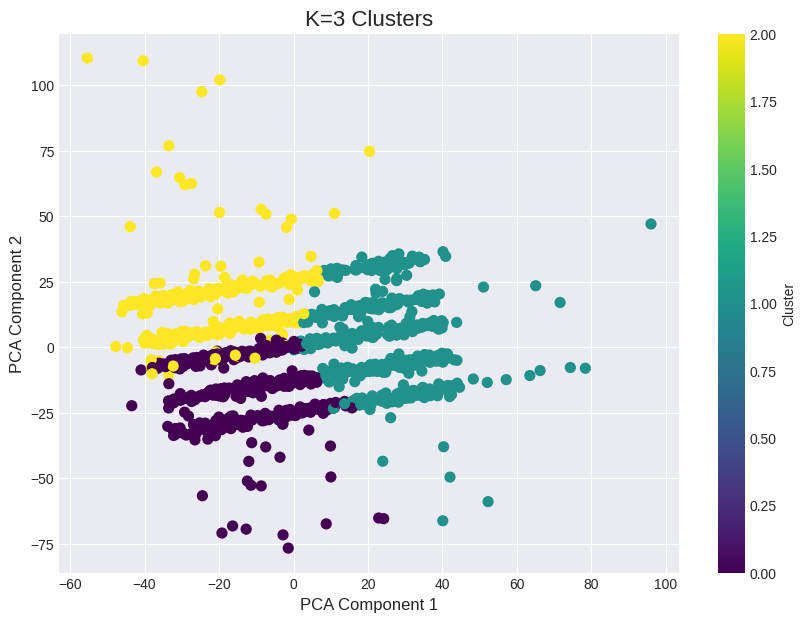

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming df and refined_features are already defined and k-means clustering is performed with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
labels_k3 = kmeans.fit_predict(df[refined_features])
df['Cluster_K3'] = labels_k3

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(df[refined_features])

# Visualize the K=3 clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels_k3, cmap='viridis', s=50)
plt.title("K=3 Clusters", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster")
plt.show()



# K=3 CLusters Analysis

In [ ]:
# Summarize numerical features by new clusters
numerical_summary_k3 = df.groupby('Cluster_K3')[refined_features].mean()
print("Numerical Feature Summary by K=3 Clusters:")
print(numerical_summary_k3)

# Summarize categorical feature distributions
for feature in categorical_features:
    print(f"\n{feature} Distribution by K=3 Clusters:")
    print(df.groupby('Cluster_K3')[feature].value_counts(normalize=True))


Numerical Feature Summary by K=3 Clusters:
            State of Charge (Start %)  Battery Capacity (kWh)  \
Cluster_K3                                                      
0                           31.864372               60.907592   
1                           73.657682               71.166141   
2                           33.531216               95.839296   

            Temperature (°C)  Charging Rate (kW)  
Cluster_K3                                        
0                  15.358748           24.827716  
1                  16.165159           26.466645  
2                  13.816099           26.577878  

Vehicle Model Distribution by K=3 Clusters:
Cluster_K3  Vehicle Model
0           4                0.237209
            3                0.206977
            1                0.204651
            0                0.176744
            2                0.174419
1           1                0.209040
            2                0.209040
            3                0.199623
 

In [ ]:
df['Efficiency (kWh/hour)'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']
efficiency_summary = df.groupby('Cluster_K3')['Efficiency (kWh/hour)'].mean()
print(efficiency_summary)


Cluster_K3
0    27.342710
1    26.076164
2    25.970546
Name: Efficiency (kWh/hour), dtype: float64


Vehicle Model Distribution by Cluster:
    Cluster_K3  Vehicle Model  Count  Proportion
0            0              0     70    0.169903
1            0              1     85    0.206311
2            0              2     72    0.174757
3            0              3     83    0.201456
4            0              4    102    0.247573
5            1              0    105    0.196262
6            1              1    113    0.211215
7            1              2    112    0.209346
8            1              3    107    0.200000
9            1              4     98    0.183178
10           2              0     83    0.222520
11           2              1     58    0.155496
12           2              2     82    0.219839
13           2              3     70    0.187668
14           2              4     80    0.214477

User Type Distribution by Cluster:
   Cluster_K3  User Type  Count  Proportion
0           0          0    134    0.325243
1           0          1    146    0.354369
2        

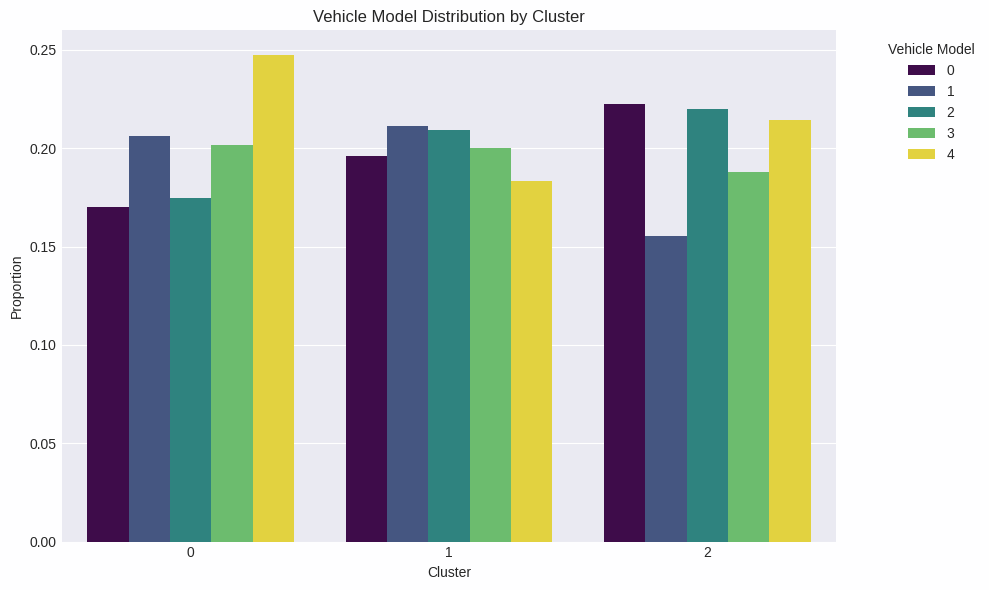

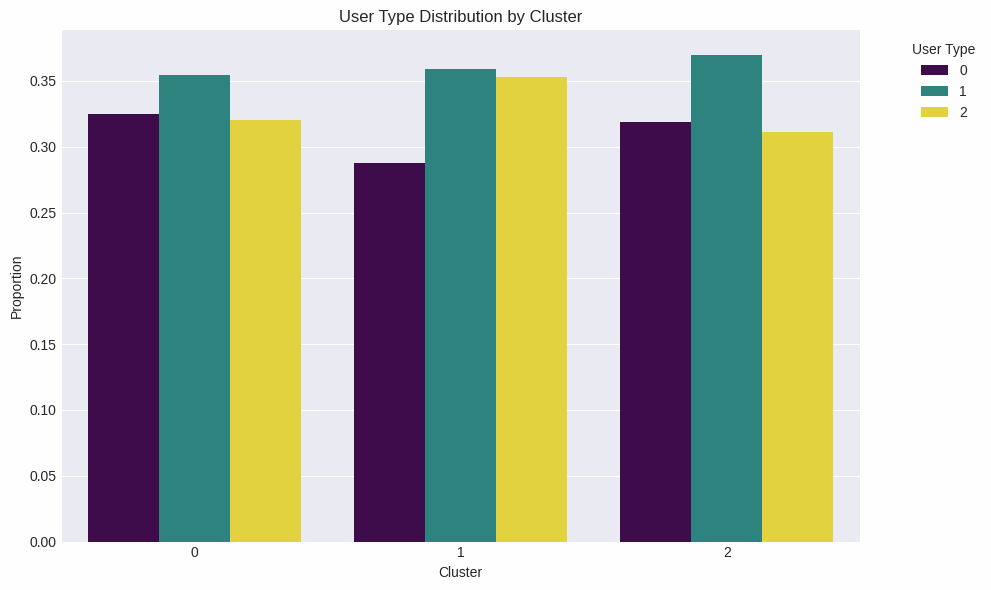

In [ ]:
# Ensure the column Cluster_K3 is not reassigned or duplicated
if 'Cluster_K3' not in df.columns:
    raise ValueError("The column 'Cluster_K3' does not exist in the DataFrame. Please check your clustering step.")

# Calculate the proportion of each vehicle model in each cluster
vehicle_model_distribution = (
    df.groupby(['Cluster_K3', 'Vehicle Model'])
    .size()
    .reset_index(name='Count')
)

# Normalize proportions by cluster
vehicle_model_distribution['Proportion'] = vehicle_model_distribution.groupby('Cluster_K3')['Count'].transform(lambda x: x / x.sum())

# Calculate the proportion of each user type in each cluster
user_type_distribution = (
    df.groupby(['Cluster_K3', 'User Type'])
    .size()
    .reset_index(name='Count')
)

# Normalize proportions by cluster
user_type_distribution['Proportion'] = user_type_distribution.groupby('Cluster_K3')['Count'].transform(lambda x: x / x.sum())

# Display the results
print("Vehicle Model Distribution by Cluster:")
print(vehicle_model_distribution)

print("\nUser Type Distribution by Cluster:")
print(user_type_distribution)

# Optional: Save to CSV for detailed review
vehicle_model_distribution.to_csv("vehicle_model_distribution_by_cluster.csv", index=False)
user_type_distribution.to_csv("user_type_distribution_by_cluster.csv", index=False)

# Visualization (Optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Vehicle Model Distribution Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    data=vehicle_model_distribution,
    x="Cluster_K3",
    y="Proportion",
    hue="Vehicle Model",
    palette="viridis"
)
plt.title("Vehicle Model Distribution by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="Vehicle Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# User Type Distribution Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    data=user_type_distribution,
    x="Cluster_K3",
    y="Proportion",
    hue="User Type",
    palette="viridis"
)
plt.title("User Type Distribution by Cluster")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.legend(title="User Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Predictive Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define features and target for cluster prediction
features = ['State of Charge (Start %)', 'Battery Capacity (kWh)', 'Temperature (°C)', 'Charging Rate (kW)']
target = 'Cluster_K3'

# Split data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict cluster membership for the test set
y_pred = clf.predict(X_test)

# Evaluate classification performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Cluster Membership Prediction - Accuracy: {accuracy:.3f}, F1-Score: {f1:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance for interpretability
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)


Cluster Membership Prediction - Accuracy: 0.989, F1-Score: 0.989
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        87
           1       0.98      1.00      0.99       110
           2       1.00      0.97      0.98        67

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264


Feature Importance:
                     Feature  Importance
0  State of Charge (Start %)    0.571903
1     Battery Capacity (kWh)    0.396276
3         Charging Rate (kW)    0.018573
2           Temperature (°C)    0.013249


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define features for energy demand prediction
features_energy = [
    'State of Charge (Start %)', 'Battery Capacity (kWh)', 'Temperature (°C)',
    'Charging Rate (kW)', 'Distance Driven (since last charge) (km)',
    'Charging Duration (hours)', 'Vehicle Age (years)'
]

# Define features for charging cost prediction
features_cost = [
    'State of Charge (Start %)', 'Battery Capacity (kWh)', 'Temperature (°C)',
    'Charging Rate (kW)', 'Charger Type', 'Time of Day',
    'Charging Station Location', 'Charging Duration (hours)'
]

target_energy = 'Energy Consumed (kWh)'
target_cost = 'Charging Cost (USD)'

# Split data into training and testing sets for energy prediction
X_energy = df[features_energy]
y_energy = df[target_energy]
X_cost = df[features_cost]
y_cost = df[target_cost]

X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
    X_energy, y_energy, test_size=0.2, random_state=42
)
X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(
    X_cost, y_cost, test_size=0.2, random_state=42
)

# Models to evaluate
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Evaluate models for energy prediction
print("Energy Demand Prediction:")
for name, model in models.items():
    model.fit(X_train_energy, y_train_energy)
    y_pred_energy = model.predict(X_test_energy)
    r2_energy = r2_score(y_test_energy, y_pred_energy)
    rmse_energy = mean_squared_error(y_test_energy, y_pred_energy, squared=False)
    print(f"{name} - R²: {r2_energy:.3f}, RMSE: {rmse_energy:.3f}")

# Evaluate models for cost prediction
print("\nCharging Cost Prediction:")
for name, model in models.items():
    model.fit(X_train_cost, y_train_cost)
    y_pred_cost = model.predict(X_test_cost)
    r2_cost = r2_score(y_test_cost, y_pred_cost)
    rmse_cost = mean_squared_error(y_test_cost, y_pred_cost, squared=False)
    print(f"{name} - R²: {r2_cost:.3f}, RMSE: {rmse_cost:.3f}")


Energy Demand Prediction:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest - R²: -0.022, RMSE: 22.512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting - R²: -0.091, RMSE: 23.260


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost - R²: -0.323, RMSE: 25.616

Charging Cost Prediction:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest - R²: -0.078, RMSE: 11.630


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Gradient Boosting - R²: -0.072, RMSE: 11.597
XGBoost - R²: -0.325, RMSE: 12.892


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Train cluster-specific models for energy demand prediction
for cluster in df['Cluster_K3'].unique():
    print(f"\nTraining model for Cluster {cluster}")
    cluster_data = df[df['Cluster_K3'] == cluster]

    # Define features and target
    X = cluster_data[features]
    y_energy = cluster_data['Energy Consumed (kWh)']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_energy, test_size=0.2, random_state=42)

    # Model
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(X_train, y_train)

    # Predictions
    y_pred = reg.predict(X_test)

    # Evaluation
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Cluster {cluster} - R²: {r2:.3f}, RMSE: {rmse:.3f}")



Training model for Cluster 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cluster 2 - R²: -0.140, RMSE: 22.825

Training model for Cluster 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cluster 0 - R²: -0.272, RMSE: 22.287

Training model for Cluster 1
Cluster 1 - R²: -0.187, RMSE: 24.106


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['State of Charge (Start %)', 'Battery Capacity (kWh)',
            'Temperature (°C)', 'Charging Rate (kW)']
target = 'Energy Consumed (kWh)'

# Train and evaluate XGBoost models for each cluster
for cluster in df['Cluster_K3'].unique():
    print(f"\nTraining XGBoost model for Cluster {cluster}")
    cluster_data = df[df['Cluster_K3'] == cluster]

    # Split data into training and testing sets
    X = cluster_data[features]
    y = cluster_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate performance
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Cluster {cluster} - R²: {r2:.3f}, RMSE: {rmse:.3f}")

    # Feature importance (optional)
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
    print("Feature Importance:")
    print(feature_importance_df)



Training XGBoost model for Cluster 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cluster 2 - R²: -0.559, RMSE: 26.690
Feature Importance:
                     Feature  Importance
3         Charging Rate (kW)    0.274308
2           Temperature (°C)    0.262165
0  State of Charge (Start %)    0.257718
1     Battery Capacity (kWh)    0.205810

Training XGBoost model for Cluster 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Cluster 0 - R²: -0.515, RMSE: 24.317
Feature Importance:
                     Feature  Importance
3         Charging Rate (kW)    0.293610
2           Temperature (°C)    0.276219
1     Battery Capacity (kWh)    0.222560
0  State of Charge (Start %)    0.207611

Training XGBoost model for Cluster 1
Cluster 1 - R²: -0.506, RMSE: 27.157
Feature Importance:
                     Feature  Importance
2           Temperature (°C)    0.287209
3         Charging Rate (kW)    0.277162
1     Battery Capacity (kWh)    0.222470
0  State of Charge (Start %)    0.213159


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Other Analysis

In [ ]:
charger_usage = df['Charging Station Location'].value_counts(normalize=True)
print(charger_usage)


Charging Station Location
2    0.225000
4    0.200000
1    0.198485
3    0.193182
0    0.183333
Name: proportion, dtype: float64


In [ ]:
import pandas as pd


# Ensure numerical columns are properly handled
df['Charging Cost (USD)'] = pd.to_numeric(df['Charging Cost (USD)'], errors='coerce')
df['Energy Consumed (kWh)'] = pd.to_numeric(df['Energy Consumed (kWh)'], errors='coerce')

# Group by 'Charging Station Location' to calculate mean Charging Cost and Energy Consumed
cost_energy_by_location = df.groupby('Charging Station Location')[['Charging Cost (USD)', 'Energy Consumed (kWh)']].mean()

# Display the results
print("Charging Cost and Energy Consumption by Location:")
print(cost_energy_by_location)



Charging Cost and Energy Consumption by Location:
                           Charging Cost (USD)  Energy Consumed (kWh)
Charging Station Location                                            
0                                    23.716254              43.459274
1                                    22.094322              44.058015
2                                    22.541434              41.474572
3                                    22.503082              42.248293
4                                    21.994874              42.185657


In [ ]:
cost_summary = df.groupby(['Charger Type', 'Time of Day'])['Charging Cost (USD)'].mean()
print(cost_summary)


Charger Type  Time of Day
0             0              24.643001
              1              23.347752
              2              24.174197
              3              22.142444
1             0              22.139535
              1              22.186638
              2              21.148702
              3              21.135892
2             0              22.643915
              1              21.518084
              2              21.939884
              3              23.805637
Name: Charging Cost (USD), dtype: float64


In [ ]:
behavior_summary = df.groupby('User Type')[
    ['Charging Duration (hours)', 'Energy Consumed (kWh)', 'Distance Driven (since last charge) (km)']
].mean()
print(behavior_summary)


           Charging Duration (hours)  Energy Consumed (kWh)  \
User Type                                                     
0                           2.284515              44.403087   
1                           2.305164              41.414134   
2                           2.216299              42.341960   

           Distance Driven (since last charge) (km)  
User Type                                            
0                                        146.312803  
1                                        158.873570  
2                                        154.633019  
